# Neutrino Trident Production

This notebook loads and tests the MC events for neutrino trident production off nuclei and protons,

$$\nu_\alpha \,+\, N \,\to\, \nu_\beta \,+\, \ell^+_{\kappa} \,+\, \ell^-_{\gamma} \,+\, N.$$

This notebook can be easily adapted to generate and analyse your own experiment definition in PATH=../exps/


Note that only the four-momenta of the final state charged leptons and neutrino are provided, together with the neutrino energy $E_\nu$ and the momentum transfer to the nuclear targer $Q^2$.

This work is directly based on $\textit{arXiv:1807.10973}$.

## Init

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from scipy import *
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.lines as mlines
from matplotlib.pyplot import *


# Neutrino Trident Production

from source import *

## Define scattering targets and the total mass to be used

CHARM-II muonic photons

In [3]:
# masses in t 
# totmass=3.57e29*1.6726219*1e-27*1e-3*(const.m_AVG)*2/(const.m_proton+const.m_neutron)
totmass=28.6
massFe=0.8*totmass
massC=0.2*totmass

# mass, Z, A, PB or noPB for pelastic events
materials = np.array([\
            [massC, 6, 12, False],
            [massFe, 26, 56, False],
            [6/12*massC + 26/56*massFe, 1, 1, True],
            [6/12*massC + (56-26)/48*massFe, 0, 1, True]]).T

# check total detector mass
nuclei_mask=np.array(1-materials[-1], dtype=bool)
total_det_mass=np.sum(materials[0][nuclei_mask])

print(f"all materials: {total_det_mass:.3f} t")

all materials: 28.600 t


## Generate trident events with exp scripts in exp

this call ./exp.sh, reads all output npy files in data/exp/ folder, and combines all generation cases (targets, nu vs nubar, scattering regime) into a single dictionary.

In [67]:
MINOS_LE_f=gen.generate_tridents("MINOS_FHC_LE",9.8e-4,0.1,materials)
MINOS_LE_r=gen.generate_tridents("MINOS_RHC_LE",9.8e-4,0.1,materials)
MINOS_ME_f=gen.generate_tridents("MINOS_FHC_ME",9.8e-4,0.1,materials)

data/MINOS_FHC_LE/
Trident channel: numu_to_numu_mu+_mu-

Integral: 0.102699+-0.000247897, Chi2 prob: 0.103389
correction: 0.148422
Total number of events: 105000
Number of NaNed events: 0
Saving events to file: data/MINOS_FHC_LE/MC_events_numu_to_numu_mu+_mu-_coh_6_12_gv_0.000980_ga_0.000000_mz_0.100000.npy
size of events: 1575000
Trident channel: numubar_to_numubar_mu+_mu-

Integral: 0.0234113+-7.84754e-05, Chi2 prob: 0.417136
correction: 0.185068
Total number of events: 105000
Number of NaNed events: 0
Saving events to file: data/MINOS_FHC_LE/MC_events_numubar_to_numubar_mu+_mu-_coh_6_12_gv_0.000980_ga_0.000000_mz_0.100000.npy
size of events: 1575000
Trident channel: numu_to_numu_mu+_mu-

Integral: 1.14386+-0.00261823, Chi2 prob: 0.0409283
correction: 0.140744
Total number of events: 105000
Number of NaNed events: 0
Saving events to file: data/MINOS_FHC_LE/MC_events_numu_to_numu_mu+_mu-_coh_26_56_gv_0.000980_ga_0.000000_mz_0.100000.npy
size of events: 1575000
Trident channel: numuba

## Compute number of events with correct normalization

In [68]:
#################
# convert event weights to # of events
invm2_to_incm2=1e-4
dE=1.0
zb_to_cm2 = 1e-45
nucleons_to_tons = const.NAvo*1e6

# NuMI LE FHC
POT_FHC_LE = 10.56e20 #1 POT
norm_FHC_LE = nucleons_to_tons*zb_to_cm2*POT_FHC_LE*invm2_to_incm2/dE

# NuMI LE RHC
POT_RHC_LE = 3.36e20 #1 POT
norm_RHC_LE = nucleons_to_tons*zb_to_cm2*POT_RHC_LE*invm2_to_incm2/dE

# NuMI ME FHC
POT_FHC_ME = 9.69e20 #1 POT
norm_FHC_ME = nucleons_to_tons*zb_to_cm2*POT_FHC_ME*invm2_to_incm2/dE

print("\n numode LE total number of events = ", np.sum(MINOS_LE_f['weights'])*norm_FHC_LE)
print("\n nubarmode LE total number of events = ", np.sum(MINOS_LE_r['weights'])*norm_RHC_LE)
print("\n numode ME total number of events = ", np.sum(MINOS_ME_f['weights'])*norm_FHC_ME)



 numode LE total number of events =  2202.5294900270292762

 nubarmode LE total number of events =  645.9830689551599177

 numode ME total number of events =  5613.3127372862536855


# Class of kinematics

In [54]:
nu = kin.kin(MINOS_LE_f,const.m_mu,const.m_mu,Emax=50)
nubar = kin.kin(MINOS_LE_r,const.m_mu,const.m_mu,Emax=50)
nume = kin.kin(MINOS_ME_f,const.m_mu,const.m_mu,Emax=50)

Total samples imported:  840000
Total samples imported:  840000
Total samples imported:  420000


## Events as a function of neutrino energy 

Comapre with ND280 -- NuMI much wider band than J-PARC, so we get more events at high energy

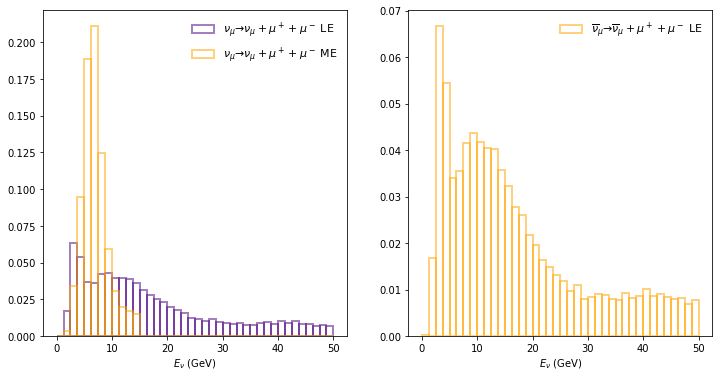

In [44]:
# plot the distribution in neutrino energy as a sanity check
def plot_nuflux(ax, colour, MC, title):
    # defs
    kwargs = {"facecolor" : "None", 
              "edgecolor" : colour,
              "lw"        : 2.0,
              "alpha"     : 0.5,
              "weights" : MC.w,
              "bins" : 40,
              "density" : True,
              "label" : title} 
    
    # hists
    h = ax.hist(MC.Enu, range=(0.0,MC.Enu_max), **kwargs)
    ax.set_xlabel(r"$E_\nu$ (GeV)")

fig,  axes = plt.subplots(nrows=1, ncols=2,figsize = (12,6))
(ax1,ax2) = axes

plot_nuflux(ax1,"indigo", nu, 
           r"$\nu_\mu \to \nu_\mu + \mu^+ + \mu^-$ LE")

plot_nuflux(ax2,"orange", nubar, 
           r"$\overline{\nu}_\mu \to \overline{\nu}_\mu + \mu^+ + \mu^-$ LE")

plot_nuflux(ax1,"orange", nume, 
           r"$\nu_\mu \to \nu_\mu + \mu^+ + \mu^-$ ME")

ax1.legend(loc="upper right", frameon=False, fontsize=11)
ax2.legend(loc="upper right", frameon=False, fontsize=11)


In [45]:
np.max(nubar.Enu)

49.999674280001486

# Check a set of kinematical distributions


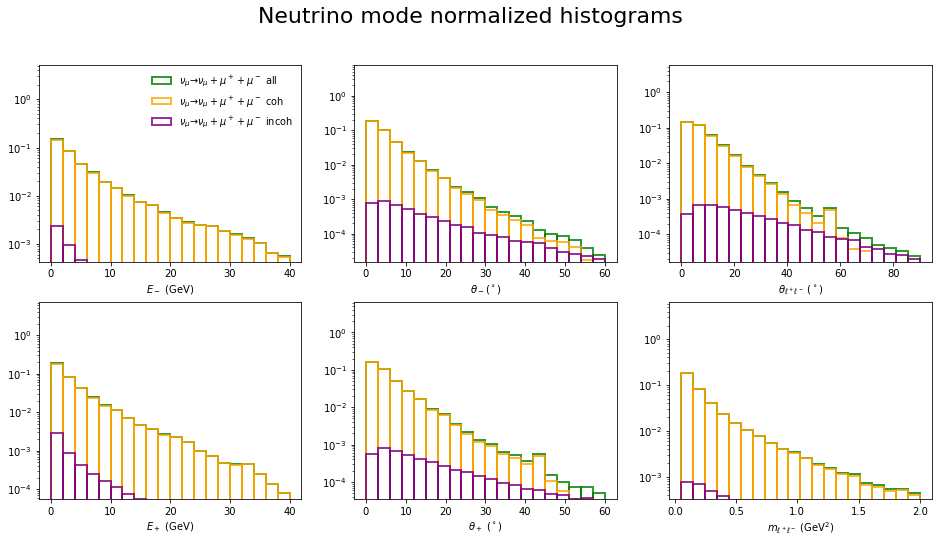

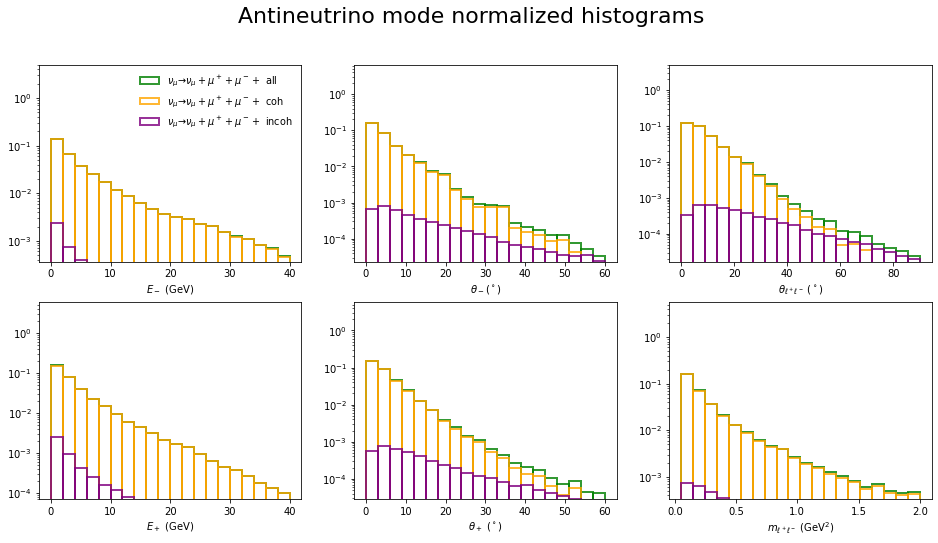

In [46]:
fsize = 14

# figs
fig1,  axes1 = plt.subplots(nrows=2, ncols=3,figsize = (16,8))
fig2,  axes2 = plt.subplots(nrows=2, ncols=3,figsize = (16,8))

def plot_dists(MC, colour, title, axes, mask):

    ((ax1, ax2, ax3), (ax4, ax5, ax6)) = axes

    # defs
    kwargs = {"facecolor" : "None", 
              "edgecolor" : colour,
              "lw"        : 2.0,
              "alpha"     : 0.8,
              "weights" : MC.w[mask],
              "bins" : 20,
              "density" : False,
              "label"  : title} 
    
    # hists
    h = ax1.hist(MC.Eminus(mask), range=(0,MC.Enu_max*0.8), **kwargs)
    ax1.set_xlabel(r"$E_-$ (GeV)")

    h = ax2.hist(MC.minus_beam(mask)*const.rad_to_deg, range=(0,60), **kwargs)
    ax2.set_xlabel(r"$\theta_-(^\circ$)")

    h = ax3.hist(MC.sepangle(mask)*const.rad_to_deg, range=(0,90), **kwargs)
    ax3.set_xlabel(r"$\theta_{\ell^+ \ell^-}$ ($^\circ$)")
    
    h = ax4.hist(MC.Eplus(mask), range=(0,MC.Enu_max*0.8), **kwargs)
    ax4.set_xlabel(r"$E_+$ (GeV)")

    h = ax5.hist(MC.plus_beam(mask)*const.rad_to_deg, range=(0,60), **kwargs)
    ax5.set_xlabel(r"$\theta_+$ ($^\circ$)")

    h = ax6.hist(MC.invmassSQR(mask), range=((MC.mm+MC.mp)**2,2.0), **kwargs)    
    ax6.set_xlabel(r"$m_{\ell^+\ell^-}$ (GeV$^2$)")
    
    for ax in axes.flatten():
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*3)


########################################
# neutrino

fig1.suptitle("Neutrino mode normalized histograms", fontsize=22)
plot_dists(nu,'green', 
           r"$\nu_\mu \to \nu_\mu + \mu^+ + \mu^-$ all", axes1, mask=nu.all_events)
plot_dists(nu,'orange', 
           r"$\nu_\mu \to \nu_\mu + \mu^+ + \mu^-$ coh", axes1, mask=nu.only_coh)
plot_dists(nu,'purple', 
           r"$\nu_\mu \to \nu_\mu + \mu^+ + \mu^-$ incoh", axes1, mask=nu.only_incoh)

axes1[0,0].legend(loc='upper right', frameon=False, fontsize=0.7*fsize)


fig2.suptitle("Antineutrino mode normalized histograms", fontsize=22)

plot_dists(nubar,'green', 
           r"$\nu_\mu \to \nu_\mu + \mu^+ + \mu^- + $ all", axes2, mask=nubar.all_events)
plot_dists(nubar,'orange', 
           r"$\nu_\mu \to \nu_\mu + \mu^+ + \mu^- + $ coh", axes2, mask=nubar.only_coh)
plot_dists(nubar,'purple', 
           r"$\nu_\mu \to \nu_\mu + \mu^+ + \mu^- + $ incoh", axes2, mask=nubar.only_incoh)

axes2[0,0].legend(loc='upper right', frameon=False, fontsize=0.7*fsize)



## Some trivial check of the numerics

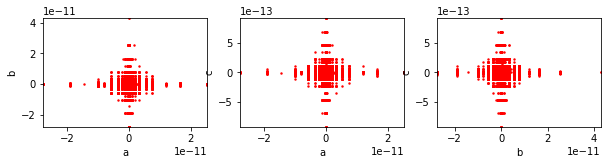

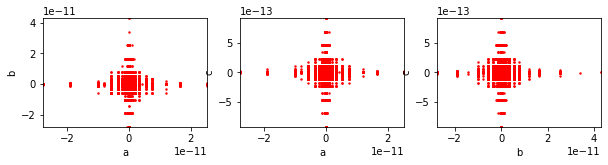

In [47]:
# Test the different kinematical limits
# charged lepton masses are recovered
def check_masses(MC):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,figsize = (10,2))
    # charged lepton masses are recovered
    mplus  = np.sqrt(Cfv.dot4(MC.Pplus, MC.Pplus))
    mminus = np.sqrt(Cfv.dot4(MC.Pminus, MC.Pminus))
    mnu = Cfv.dot4(MC.Pnu, MC.Pnu)
    
    a = mplus/MC.mp - 1.
    b = mminus/MC.mm - 1.
    c = mnu
#     a = MC.mp
#     b = MC.mm

    ax1.set_xlim(np.min(a), np.max(a)), ax1.set_ylim(np.min(b), np.max(b))
    ax2.set_xlim(np.min(a), np.max(a)), ax2.set_ylim(np.min(c), np.max(c))
    ax3.set_xlim(np.min(b), np.max(b)), ax3.set_ylim(np.min(c), np.max(c))
    ax1.set_xlabel('a'), ax1.set_ylabel('b')
    ax2.set_xlabel('a'), ax2.set_ylabel('c')
    ax3.set_xlabel('b'), ax3.set_ylabel('c')
    
    ax1.scatter(a,b, lw=0, s=6,c="r")
    ax2.scatter(a,c, lw=0, s=6,c="r")
    ax3.scatter(b,c, lw=0, s=6,c="r")

    
check_masses(nu)
check_masses(nubar)